In [1]:
# Importing the necessary libraries
import numpy as np                     # Library for numerical computations
from pykalman.pykalman import *        # Library for Kalman filtering and smoothing
import matplotlib.pyplot as plt        # Library for data visualization
from scipy import stats, spatial       # Library for statistical functions and spatial algorithms
import control                         # Library for control systems analysis and design
import emotioncon_modelling            # Custom library for emotion modeling
emo = emotioncon_modelling.Modelling() # Creating an instance of the emotion modeling class
import seaborn as sns                  # Library for statistical data visualization
sns.set(style='white', font_scale=1.5) # Setting the style and font scale for seaborn plots
filepath = '../'                       # Filepath for file operations or data access

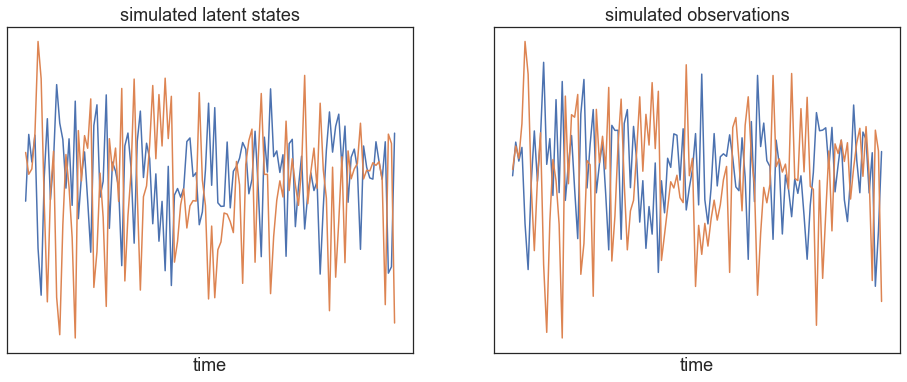

In [2]:
# Simulate data from Kalman filter and plot

# Define task dimensions
T = 120  # Number of time steps
n_dim_state = 2  # Dimension of the state
n_dim_obs = 2  # Dimension of the observations
n_dim_control = 2  # Dimension of the control inputs

# Generate control inputs (an input is observed 80% of the time)
inp = np.multiply(stats.uniform.rvs(size=[T, n_dim_control]) > 0.8, 1)

# Initialize model parameters
params = {
    'A': emo.sample_dynamicsmatrix(n_dim_state),  # State transition matrix
    'Q': 0.1 * np.eye(n_dim_obs),  # State noise covariance matrix
    'B': np.eye(n_dim_state),  # Observation matrix
    'C': stats.multivariate_normal.rvs(size=[n_dim_state, n_dim_control]),  # Input weight matrix
    'R': 0.1 * np.eye(n_dim_obs),  # Observation noise covariance matrix
    'mu_0': np.zeros(n_dim_state),  # Initial state mean
    'sigma_0': 0.1 * np.eye(n_dim_state),  # Initial state noise covariance matrix
    'h': np.zeros(n_dim_state)  # bias (set to zero)
}

opt = {'inputs': True, 'inp': inp}  # Options for the simulation, including control inputs

# Generate simulated data using the provided parameters and options
state, obs = emo.sample_lds(T, params, opt)

# Plot the simulated data
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
for i in range(2):
    axs[i].plot([state, obs][i])
    axs[i].set(title=['simulated latent states', 'simulated observations'][i], xlabel='time', \
               xticks=[], yticks=[]) # Plot time series

In [3]:
# Run simulation for different numbers of observations, without inputs, for full and diagonal noise covariances

# Define simulation options
opt = {'n_dim_state': 5, 'n_dim_obs': 5, 'n_dim_control': 5, 'inputs': False, 'maxiter': 100}
opt['em_vars'] = emo.parameter_short(['A', 'G', 'S'])  # Variables to estimate during simulation

maxrun = 1000  # Maximum number of simulation runs
number_of_observations = [10, 30, 50, 70, 90]  # Different numbers of observations

cov_options = ['diagonal', 'full']  # Covariance options: diagonal and full

# Initialize arrays to store results
dynamicsmatrix_correlation = np.empty([len(number_of_observations), maxrun, len(cov_options)])
distance_dynamics = np.empty([len(number_of_observations), maxrun, len(cov_options)])

# Perform simulations for each covariance option
for i, j in enumerate(cov_options):
    opt['cov'] = j  # Set the covariance option

    # Iterate over different numbers of observations
    for t in range(len(number_of_observations)):
        T = number_of_observations[t]  # Set the number of observations

        # Run simulation multiple times
        for r in range(maxrun):
            params = emo.initialize_lds(opt)  # Initialize model parameters
            state, obs = emo.sample_lds(T, params, opt)  # Generate simulated data

            kf = emo.run_KF(obs, opt)  # Run Kalman filter

            # Calculate correlation and distance between true dynamics and estimated dynamics
            dynamicsmatrix_correlation[t, r, i] = np.corrcoef(params['A'].flatten(), \
                                                              kf.transition_matrices.flatten())[0][1]
            distance_dynamics[t, r, i] = emo.calculate_distance(params['A'], kf.transition_matrices)

# Save the simulation results to a file
data = {'dynamics_corr': dynamicsmatrix_correlation, 'dynamics_distance': distance_dynamics}
np.save(filepath + 'results/simulations/simulation_noinputs_varying_noisecov.npy', data)

diagonal noise covariance


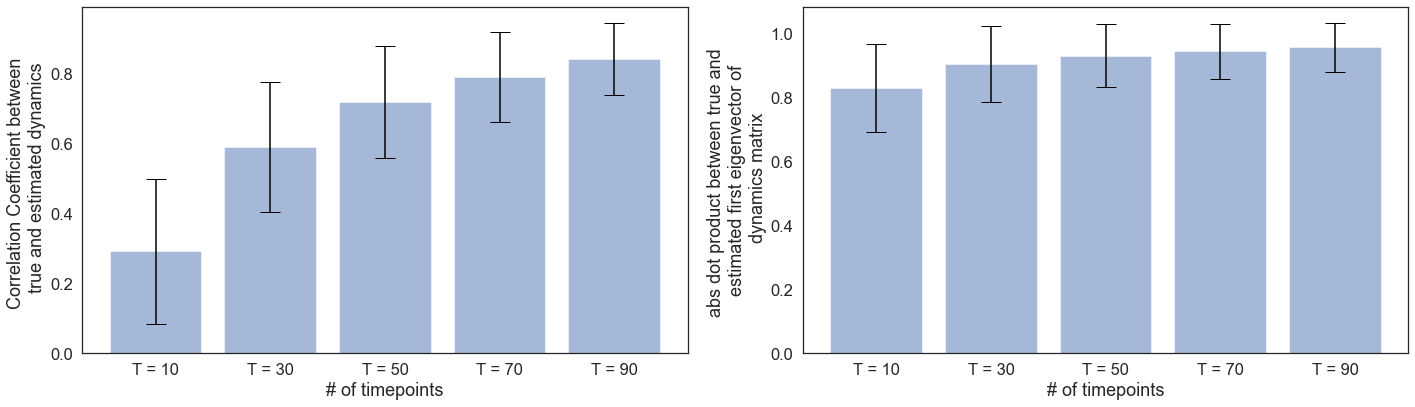

full noise covariance


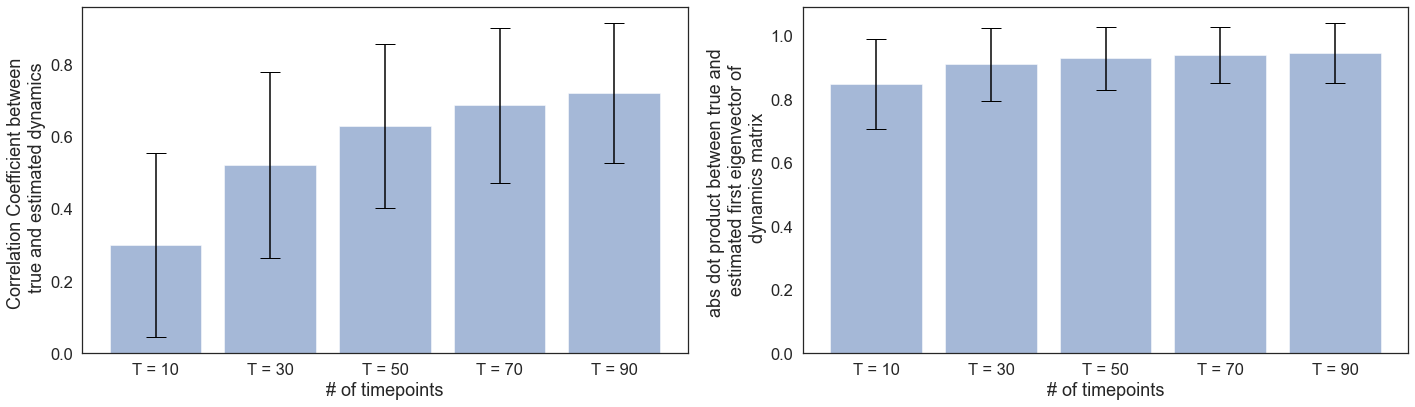

In [4]:
data = np.load(filepath + 'results/simulations/simulation_noinputs.npy', allow_pickle=True).item()
number_of_observations = [10, 30, 50, 70, 90]
x_pos = np.arange(len(number_of_observations))

# Iterate over two types of noise covariance: diagonal and full
for i in range(2):
    print(['diagonal noise covariance', 'full noise covariance'][i])
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plot correlation coefficient between true and estimated dynamics
    m = np.mean(data['dynamics_corr'][:, :, i], axis=1).T
    e = np.std(data['dynamics_corr'][:, :, i], axis=1).T
    ax[0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0].set_ylabel('Correlation Coefficient between \n true and estimated dynamics')

    # Plot absolute dot product between true and estimated first eigenvector of dynamics matrix
    m = np.mean(data['dynamics_distance'][:, :, i], axis=1).T
    e = np.std(data['dynamics_distance'][:, :, i], axis=1).T
    ax[1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1].set_ylabel('abs dot product between true and \n estimated first eigenvector of \n dynamics matrix')

    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_xticks(x_pos)
        ax[j].set_xlabel('# of timepoints')
        ax[j].set_xticklabels(['T = ' + str(n) for n in number_of_observations])

    plt.tight_layout()
    plt.show()

In [5]:
# run for different number of observentions WITH inputs

# Set options for the simulation
opt = {
    'n_dim_state': 5,
    'n_dim_obs': 5,
    'n_dim_control': 5,
    'inputs': True,
    'cov': 'diagonal',
    'maxiter': 100,
    'constraint control': False
}
opt['em_vars'] = emo.parameter_short(['A', 'C', 'G', 'S'])

maxrun = 100
number_of_observations = [10, 30, 50, 70, 90]
dim_observations = [5]

# Initialize arrays to store results
dynamicsmatrix_correlation = np.empty([len(number_of_observations), maxrun, len(dim_observations)])
distance_dynamics = np.empty([len(number_of_observations), maxrun, len(dim_observations)])
inputmatrix_correlation = np.empty([len(number_of_observations), maxrun, len(dim_observations)])
distance_control = np.empty([len(number_of_observations), maxrun, len(dim_observations)])

# Iterate over different observation dimensions and number of observations
for i, j in enumerate(dim_observations):
    for t in range(len(number_of_observations)):
        T = number_of_observations[t]

        # Create inputs for the simulation
        opt['inp'] = emo.create_inputs(T, opt['n_dim_control'])

        for r in range(maxrun):
            # Initialize the LDS model parameters
            params = emo.initialize_lds(opt)

            # Generate samples from the LDS model
            state, obs = emo.sample_lds(T, params, opt)

            # Run the Kalman Filter
            kf = emo.run_KF(obs, opt)

            # Calculate correlations and distances
            dynamicsmatrix_correlation[t, r, i] = np.corrcoef(params['A'].flatten(), kf.transition_matrices.flatten())[0][1]
            inputmatrix_correlation[t, r, i] = np.corrcoef(params['C'].flatten(), kf.control_matrix.flatten())[0][1]
            distance_dynamics[t, r, i] = emo.calculate_distance(params['A'], kf.transition_matrices)
            true_controlmatrix = control.ctrb(params['A'], params['C'])
            est_controlmatrix = control.ctrb(kf.transition_matrices, kf.control_matrix)
            distance_control[t, r, i] = emo.calculate_distance(np.dot(true_controlmatrix, true_controlmatrix.T), 
                                                              np.dot(est_controlmatrix, est_controlmatrix.T))

# Save the results to a file
data = {
    'dynamics_corr': dynamicsmatrix_correlation,
    'input_corr': inputmatrix_correlation,
    'dynamics_distance': distance_dynamics,
    'controllability_distance': distance_control
}
np.save(filepath + 'results/simulation_inputs.npy', data)

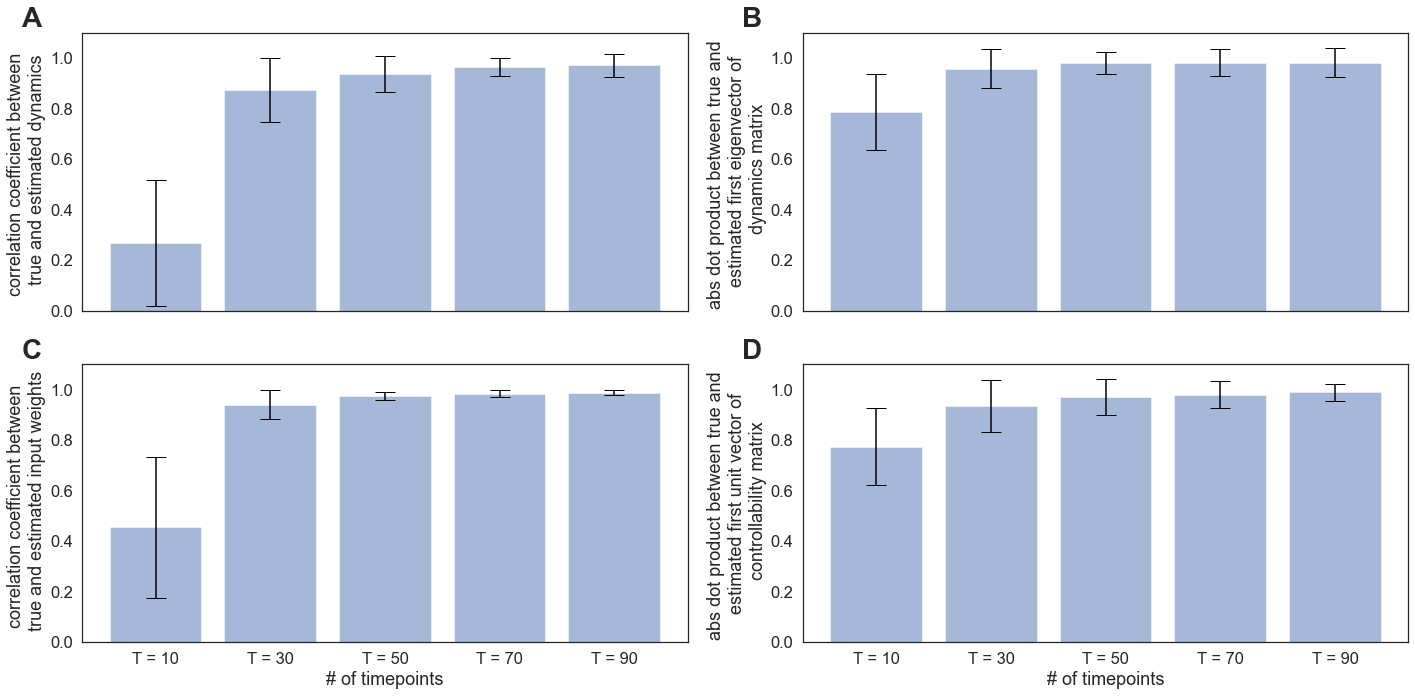

In [6]:
# Load simulation data
data = np.load(filepath + 'results/simulations/simulation_inputs.npy', allow_pickle='TRUE').item()

# Create a figure with subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define the number of observations
number_of_observations = [10, 30, 50, 70, 90]
x_pos = np.arange(len(number_of_observations))

# Plot dynamics correlation and distance
for i in range(1):
    m = np.mean(data['dynamics_corr'][:, :, i], axis=1).T
    e = np.std(data['dynamics_corr'][:, :, i], axis=1).T
    ax[0, 0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0, 0].set_ylabel('correlation coefficient between \n true and estimated dynamics')
    
    m = np.mean(data['dynamics_distance'][:, :, i], axis=1).T
    e = np.std(data['dynamics_distance'][:, :, i], axis=1).T
    ax[0, 1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[0, 1].set_ylabel('abs dot product between true and \n estimated first eigenvector of \n dynamics matrix')

    for j in range(2):
        ax[0, j].set_xticklabels([])
        ax[0, j].set_ylim([0, 1.1])
        ax[0, j].text(-0.1, 1.02, ['A', 'B'][j], transform=ax[0, j].transAxes, weight='bold', size=28)

# Plot input correlation and controllability distance
for i in range(1):
    m = np.mean(data['input_corr'][:, :, i], axis=1).T
    e = np.std(data['input_corr'][:, :, i], axis=1).T
    ax[1, 0].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1, 0].set_ylabel('correlation coefficient between \n true and estimated input weights')

    m = np.mean(data['controllability_distance'][:, :, i], axis=1).T
    e = np.std(data['controllability_distance'][:, :, i], axis=1).T
    ax[1, 1].bar(x_pos, m, yerr=e, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[1, 1].set_ylabel('abs dot product between true and \n estimated first unit vector of \n controllability matrix')

    for j in range(2):
        ax[1, j].set_xticks([])
        ax[1, j].set_xticks(x_pos)
        ax[1, j].set_xlabel('# of timepoints') 
        ax[1, j].set_xticklabels(['T = ' + str(n) for n in number_of_observations])
        ax[1, j].set_ylim([0, 1.1])
        ax[1, j].text(-0.1, 1.02, ['C', 'D'][j], transform=ax[1, j].transAxes, weight='bold', size=28)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(filepath + 'results/figures/simulation_inputs.svg')